Analisis mesual

Veremos un poco como se comportan las métricas principales para los meses que estamos evaluando (dichas imagenes se pueden generar al descomentar la celda de codigo de abajo pero se encuentran ya guardadas como png en el repositorio)

In [2]:
#!pip install lightgbm
#!pip install --upgrade lightgbm
#!pip install category_encoders
#!pip install geopy

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import logging
import os
import shutil
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [5]:
data = pd.read_csv('final_dataset.csv')
data

,trans_date_trans_time,cc_num,merchant,category,amt,lat,long,trans_num,unix_time,merch_lat,...,yearly_txn_count_by_cat,season,seasonal_txn_count_by_cat,time_diff_hours,transaction_speed,amt_to_daily_avg,amt_to_monthly_avg,txn_count_last_hour,new_merchant,amt_to_annual_avg
0,2019-01-03 01:39:04,180011453250192,"fraud_Huel, Hammes and Witting",grocery_pos,90.37,41.2153,-90.9879,96a9fd4073d93d59eca9622dc21802c4,1325554744,41.810204,...,1,Winter,1,NaN,0.000000,0.225391,0.804453,1.0,True,0.925752
1,2019-01-03 05:51:22,180011453250192,fraud_Huel-Langworth,misc_net,108.09,41.2153,-90.9879,04cf40b2f392f3932b2532a92f1ef538,1325569882,41.016419,...,1,Winter,1,4.0,11.951459,0.269586,0.962193,1.0,True,1.107276
2,2019-01-03 14:48:47,180011453250192,fraud_Lemke and Sons,travel,447.52,41.2153,-90.9879,90d74d1a15d29a250fedbabe6721a483,1325602127,41.734914,...,1,Winter,1,8.0,8.712667,1.116156,3.983721,1.0,True,4.584404
3,2019-01-04 10:39:10,180011453250192,"fraud_Christiansen, Goyette and Schamberger",gas_transport,73.17,41.2153,-90.9879,52f1b4392482195579c35df07514962a,1325673550,40.744024,...,1,Winter,1,19.0,3.096099,0.182493,0.651343,1.0,True,0.749555
4,2019-01-04 12:48:21,180011453250192,fraud_Ruecker-Mayert,kids_pets,47.55,41.2153,-90.9879,63954f859ede83d209aece226970441b,1325681301,41.462258,...,1,Winter,1,2.0,41.738353,0.118594,0.423279,1.0,True,0.487103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 14:49:51,676372984911,fraud_Kris-Padberg,shopping_pos,6.13,39.7562,-98.4462,e327aa916b4317b8baf9d181855bf9df,1388501391,39.553152,...,145,Winter,96,3.0,24.693907,0.019995,0.087796,1.0,False,0.094527
1852390,2020-12-31 16:17:19,676372984911,fraud_Schiller Ltd,personal_care,62.99,39.7562,-98.4462,2d10acccfe94d134bdac9c41c614cb00,1388506639,40.024226,...,145,Winter,95,1.0,34.733267,0.205466,0.902169,1.0,False,0.971327
1852391,2020-12-31 20:21:23,676372984911,fraud_Pollich LLC,home,28.11,39.7562,-98.4462,24ffee6f547efdbffcf471498e55e0eb,1388521283,40.412189,...,195,Winter,88,4.0,21.983892,0.091692,0.402603,1.0,False,0.433466
1852392,2020-12-31 20:58:25,676372984911,"fraud_Hayes, Marquardt and Dibbert",misc_net,211.32,39.7562,-98.4462,898279ea0067e89917bdf288f96d6834,1388523505,40.240147,...,91,Winter,36,0.0,inf,0.689301,3.026613,2.0,False,3.258625


In [6]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'lat',
       'long', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'amt_month', 'amt_year', 'amt_month_shopping_net_spend',
       'count_month_shopping_net', 'first_time_at_merchant',
       'time_since_last_txn', 'avg_daily_amt', 'hour',
       'avg_hourly_transactions', 'prev_lat', 'prev_long',
       'distance_from_last_txn', 'month_year', 'monthly_spending_variation',
       'weekday', 'is_holiday', 'first_txn_time', 'days_since_first_txn',
       'txn_count_last_24h', 'avg_amt_last_24h', 'std_amt_last_24h',
       'online_txn_ratio', 'trans_date', 'monthly_txn_count_by_cat',
       'trans_year', 'yearly_txn_count_by_cat', 'season',
       'seasonal_txn_count_by_cat', 'time_diff_hours', 'transaction_speed',
       'amt_to_daily_avg', 'amt_to_monthly_avg', 'txn_count_last_hour',
       'new_merchant', 'amt_to_annual_avg'],
      dtype='object')

In [7]:
columns_to_encode = ['merchant', 'category', 'trans_num', 'cc_num']

with open('label_encodings.txt', 'w') as file:
    for col in columns_to_encode:
        encoder = LabelEncoder()
        data[col + '_encoded'] = encoder.fit_transform(data[col])
        mappings = {index: label for index, label in enumerate(encoder.classes_)}
        file.write(f"{col} mappings:\n")
        for key, value in mappings.items():
            file.write(f"{key}: {value}\n")
        file.write("\n")

data.drop(columns=columns_to_encode, axis=1, inplace=True)

In [8]:
non_numeric_columns = data.select_dtypes(include=['object']).columns

print("Columnas no numéricas que podrían necesitar codificación:")
non_numeric_columns

Columnas no numéricas que podrían necesitar codificación:


Index(['trans_date_trans_time', 'month_year', 'first_txn_time', 'trans_date',
       'season'],
      dtype='object')

In [9]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data.set_index('trans_date_trans_time', inplace=True)

In [10]:
monthly_groups = data.groupby(pd.Grouper(freq='M'))
monthly_datasets = {}
for name, group in monthly_groups:
    print(f"Datos para el mes: {name}")
    monthly_datasets[name] = group
    print(group.head())
    print("\n-------------------------------------------\n")

Datos para el mes: 2019-01-31 00:00:00
                          amt      lat      long   unix_time  merch_lat  \
trans_date_trans_time                                                     
2019-01-01 00:00:18      4.97  36.0788  -81.1781  1325376018  36.011293   
2019-01-01 00:00:44    107.23  48.8878 -118.2105  1325376044  49.159047   
2019-01-01 00:00:51    220.11  42.1808 -112.2620  1325376051  43.150704   
2019-01-01 00:01:16     45.00  46.2306 -112.1138  1325376076  47.034331   
2019-01-01 00:03:06     41.96  38.4207  -79.4629  1325376186  38.674999   

                       merch_long  is_fraud  amt_month  amt_year  \
trans_date_trans_time                                              
2019-01-01 00:00:18    -82.048315         0       4.97      4.97   
2019-01-01 00:00:44   -118.186462         0     107.23    107.23   
2019-01-01 00:00:51   -112.154481         0     220.11    220.11   
2019-01-01 00:01:16   -112.561071         0      45.00     45.00   
2019-01-01 00:03:06    -78.

In [11]:
output_dir = 'analisis_mensual'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
else:
    shutil.rmtree(output_dir)
    os.makedirs(output_dir)

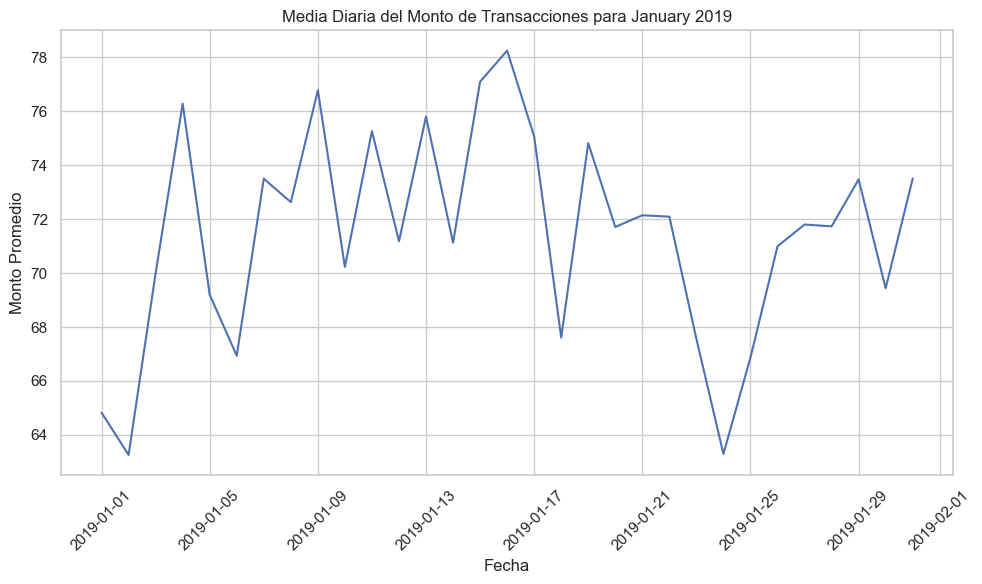

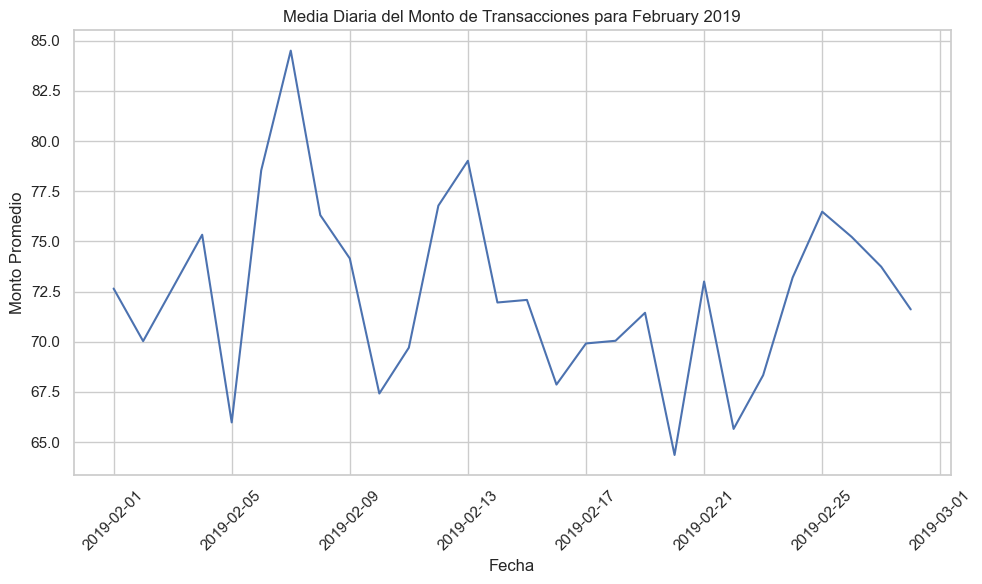

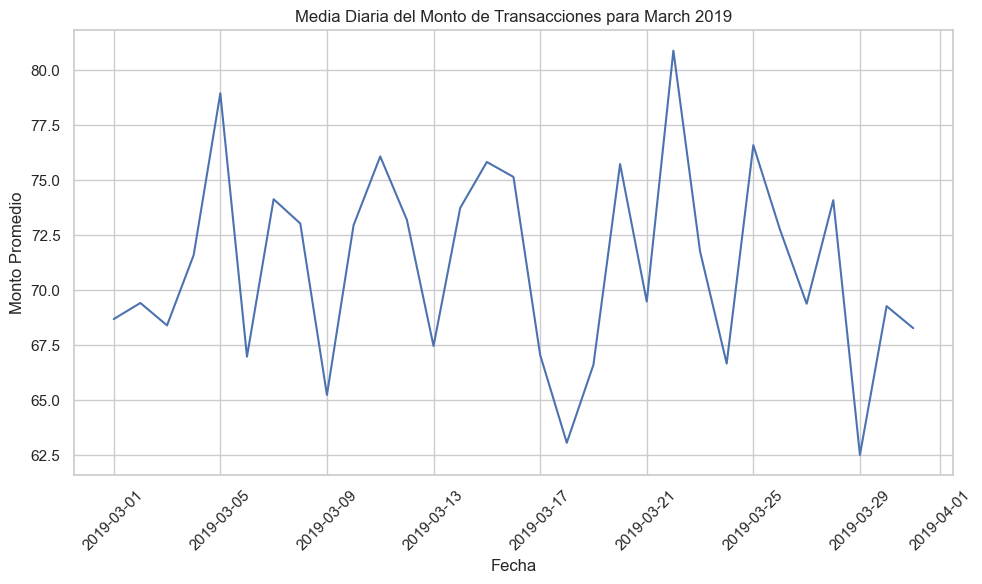

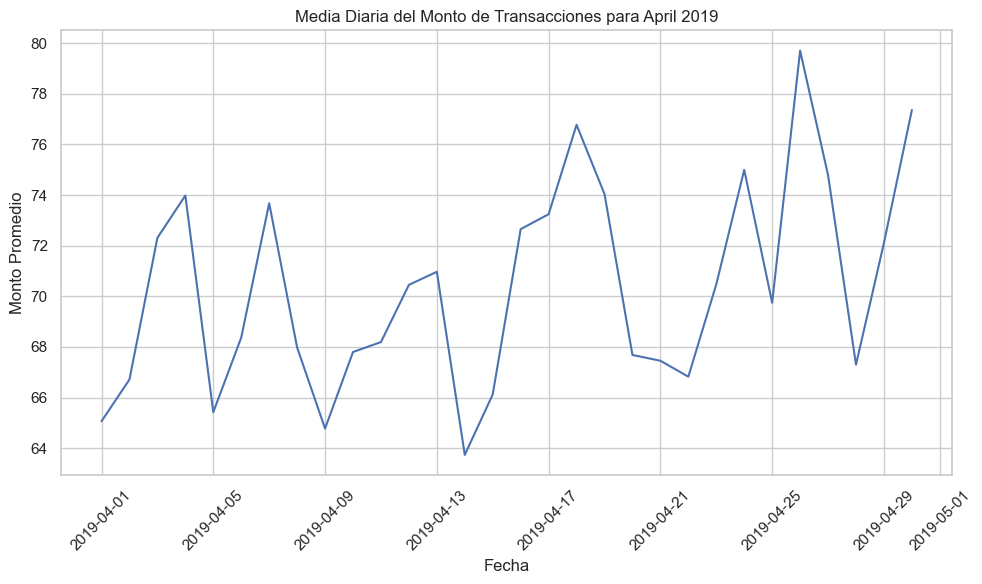

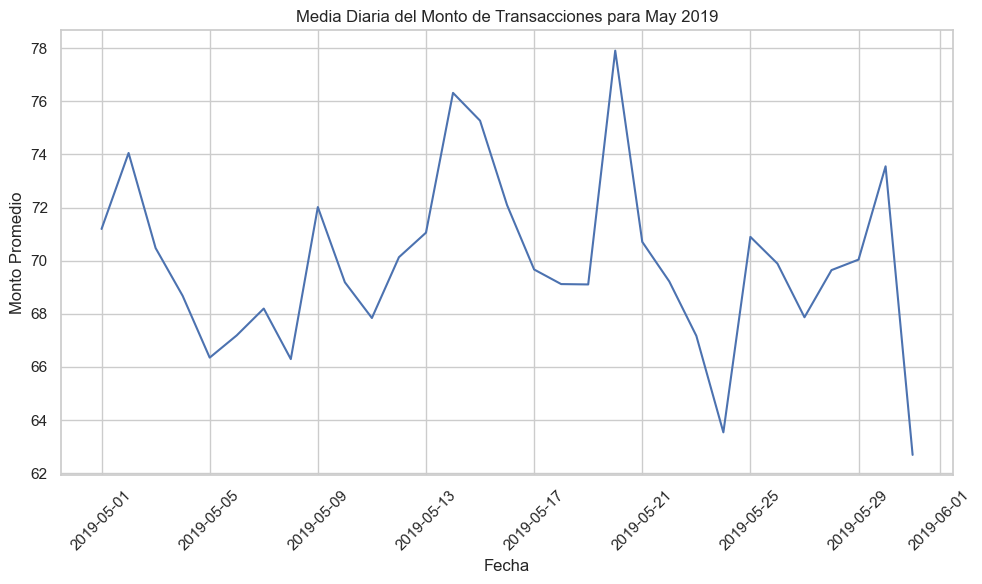

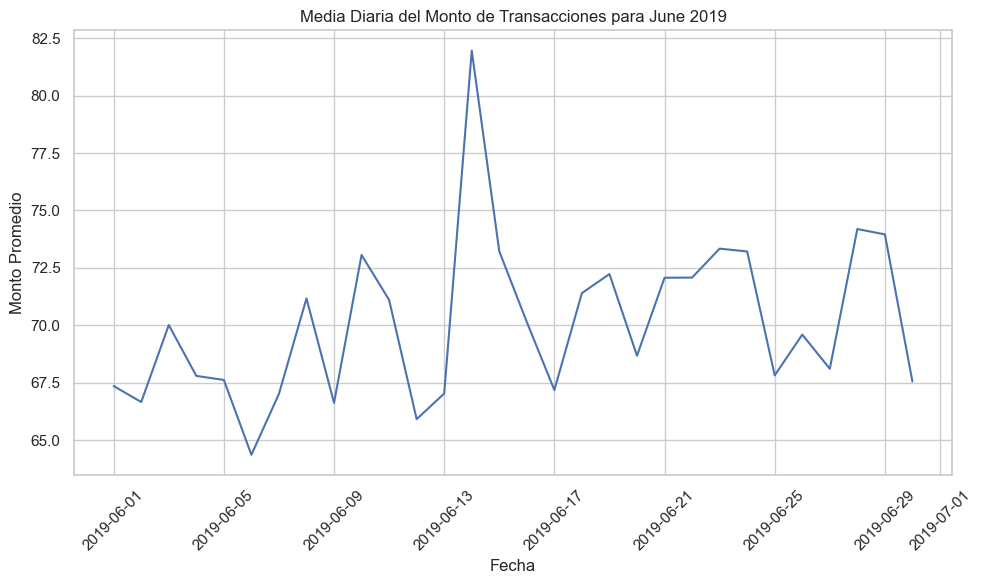

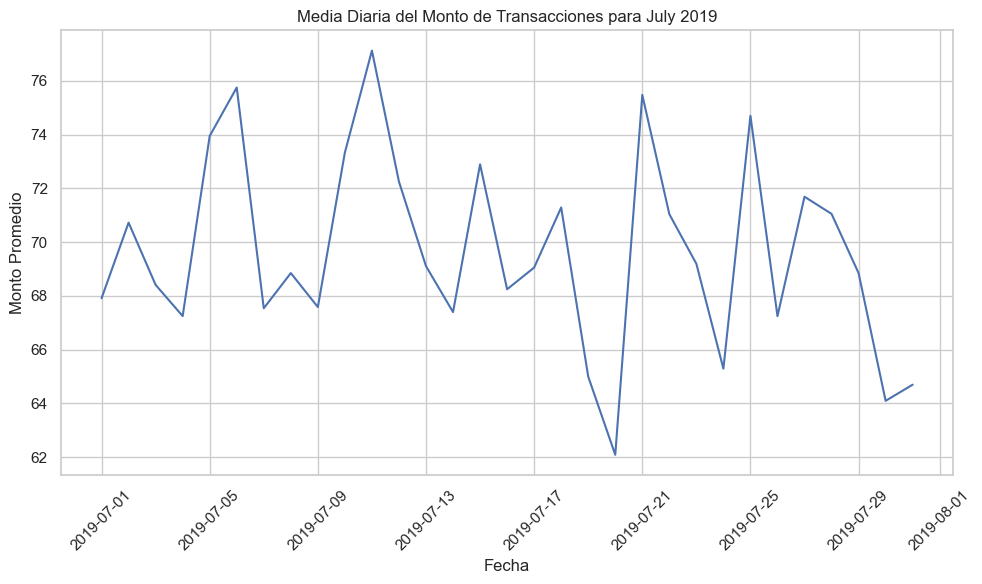

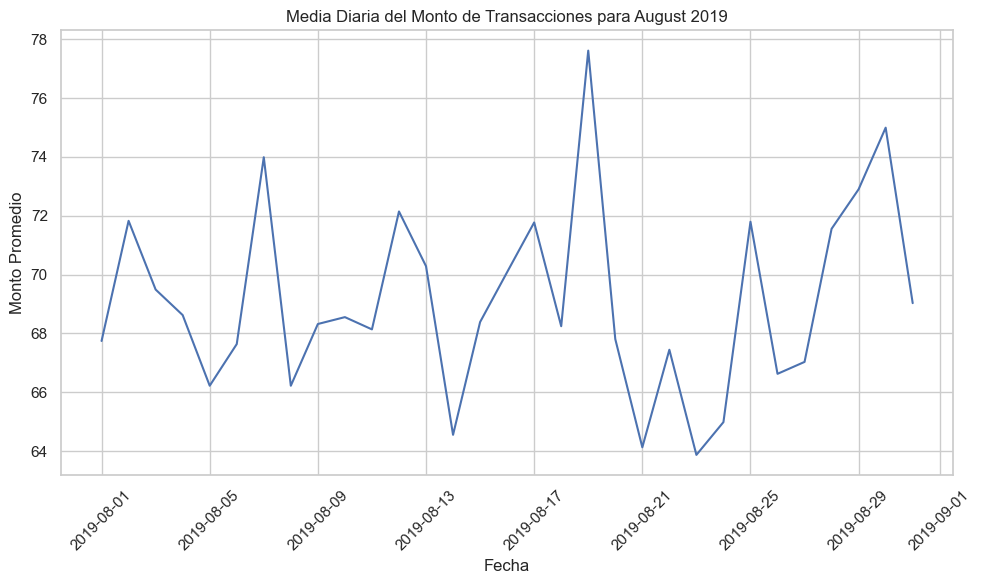

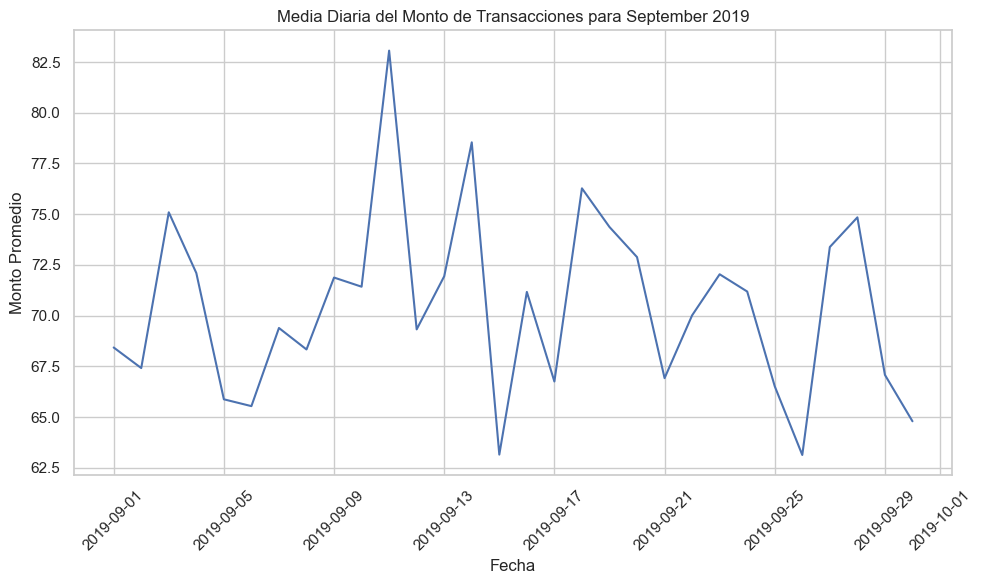

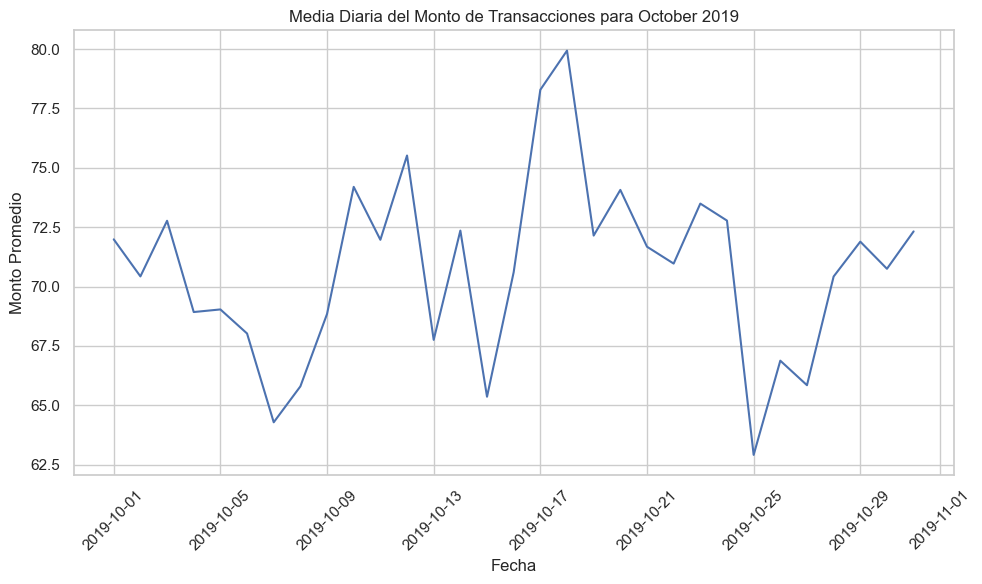

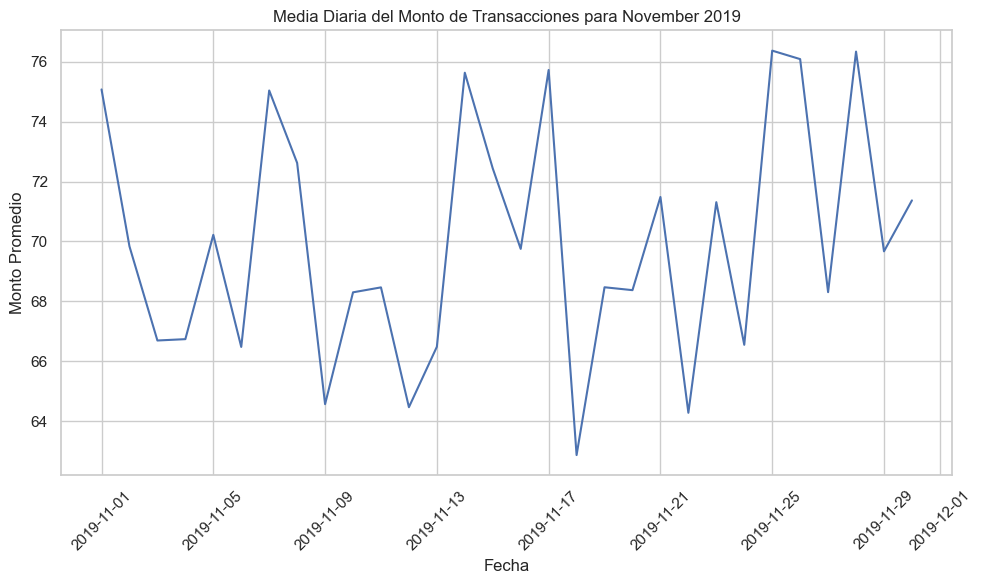

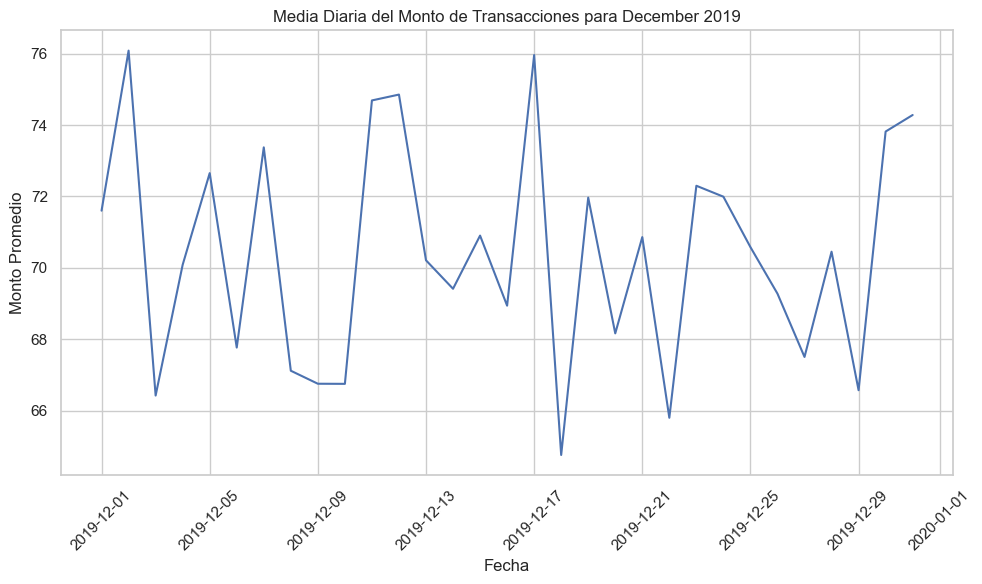

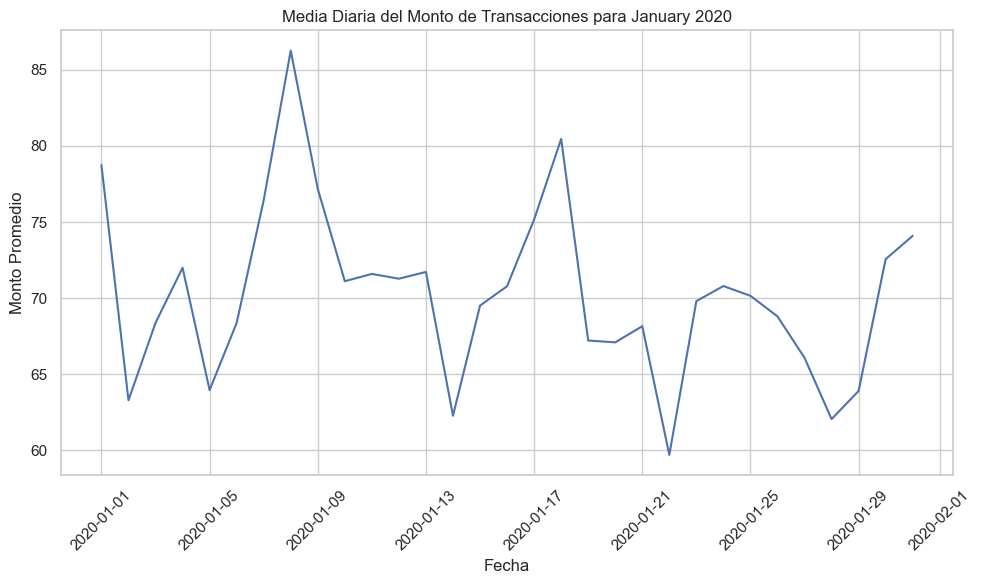

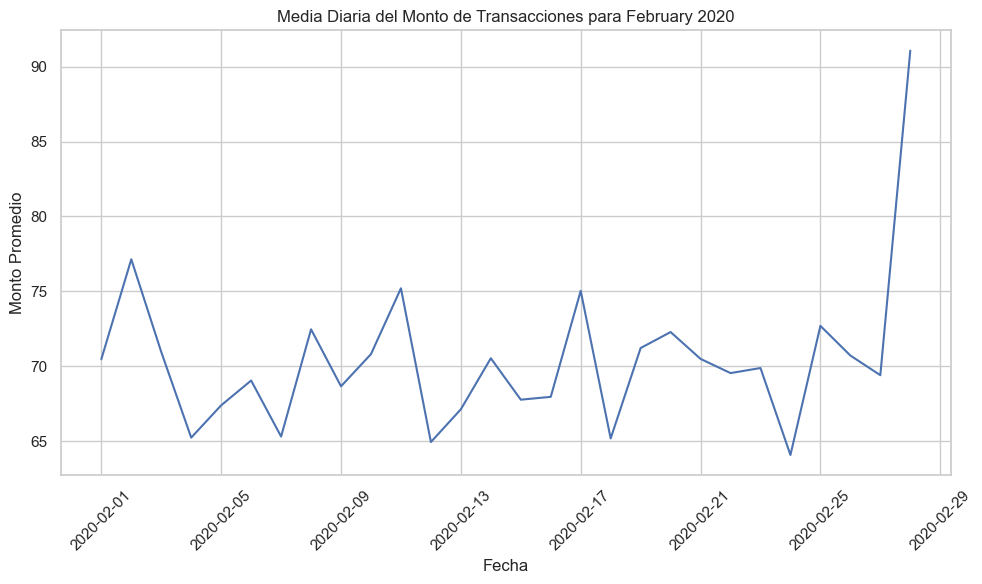

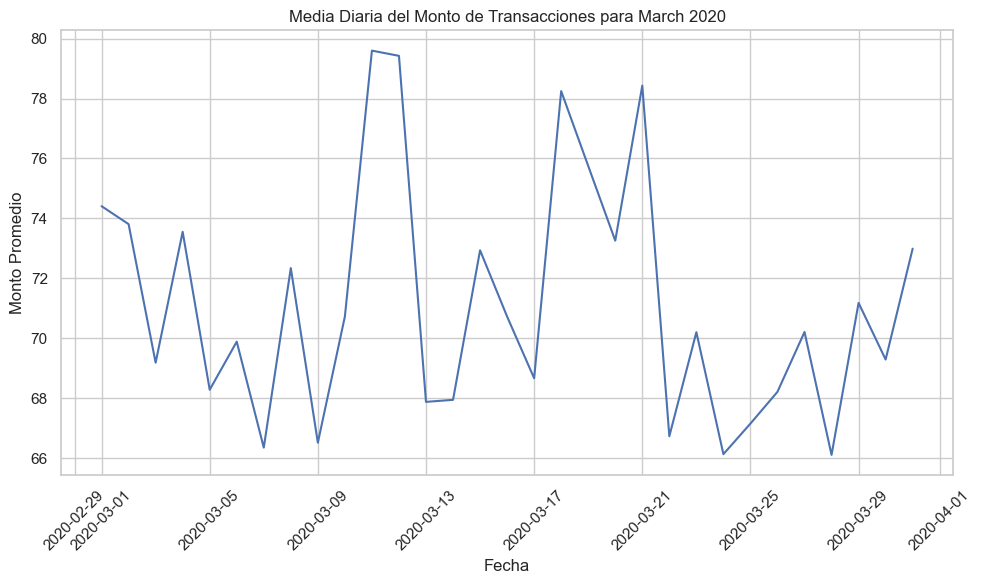

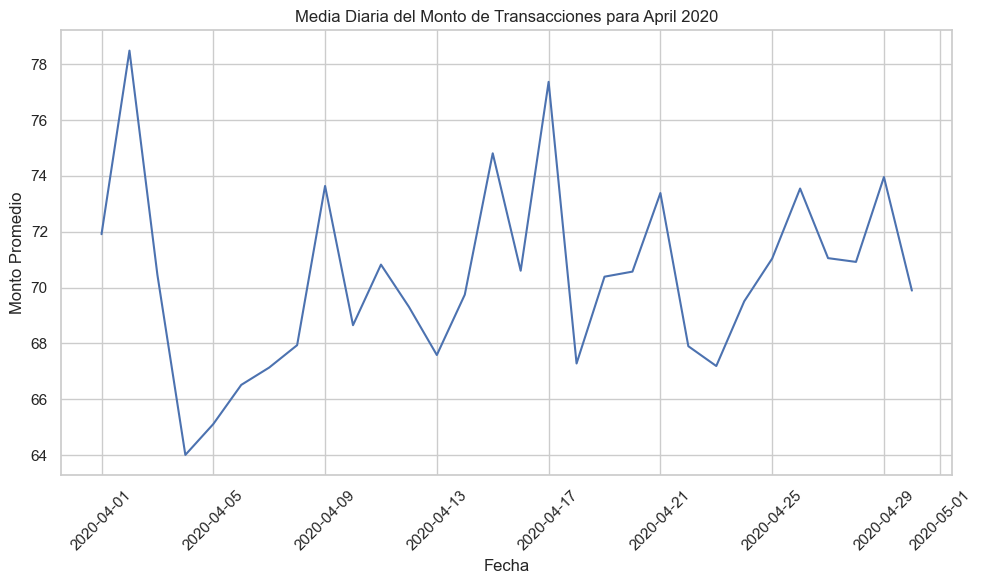

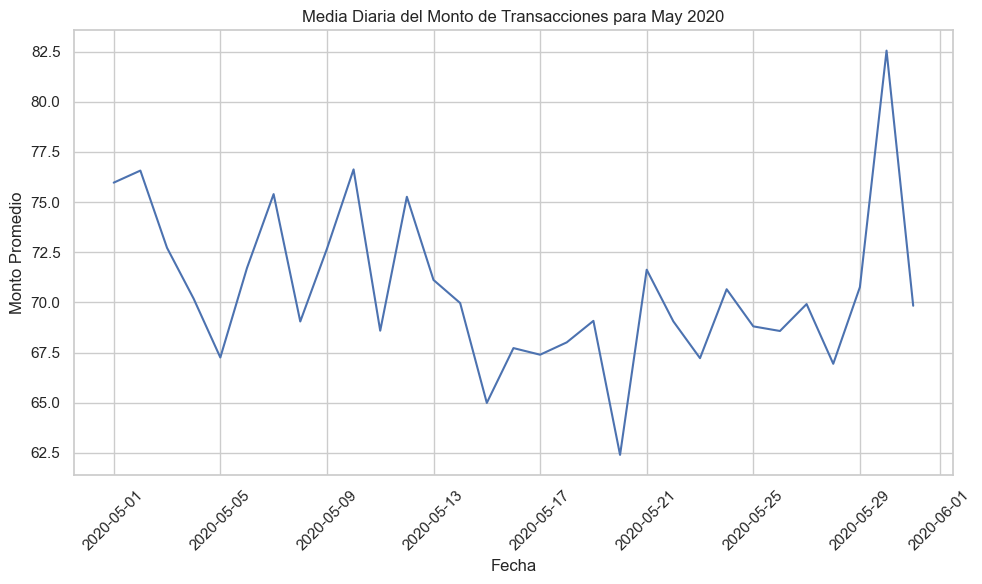

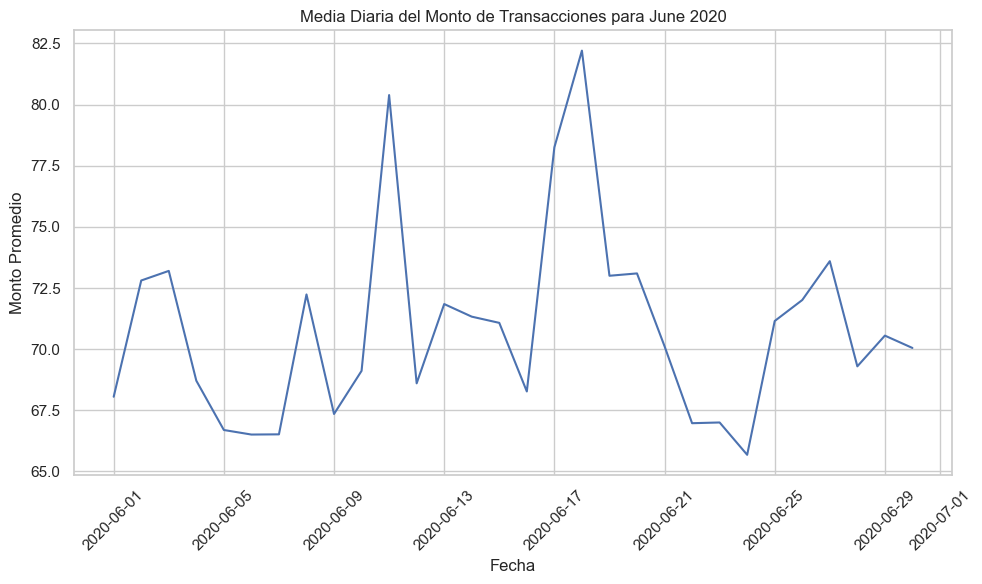

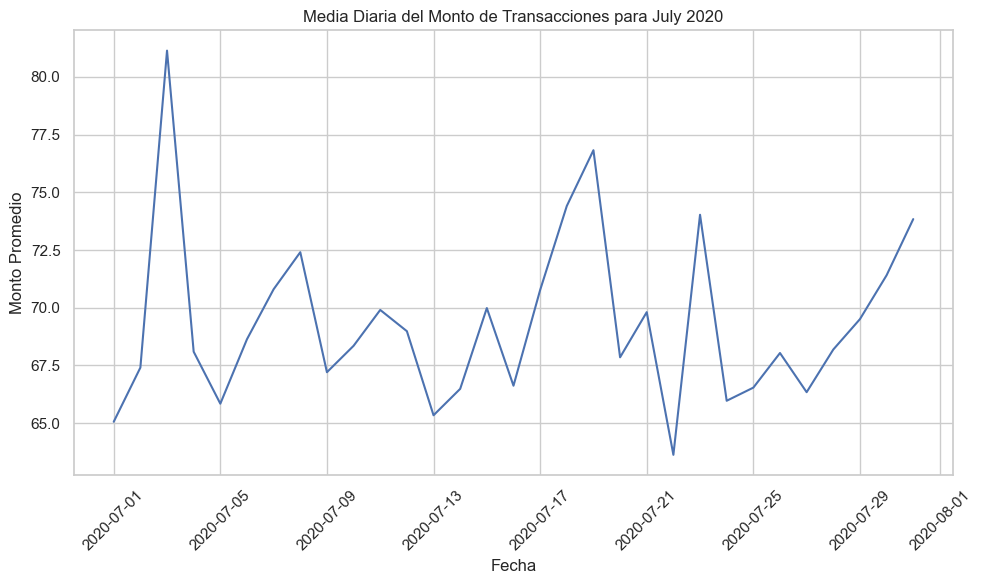

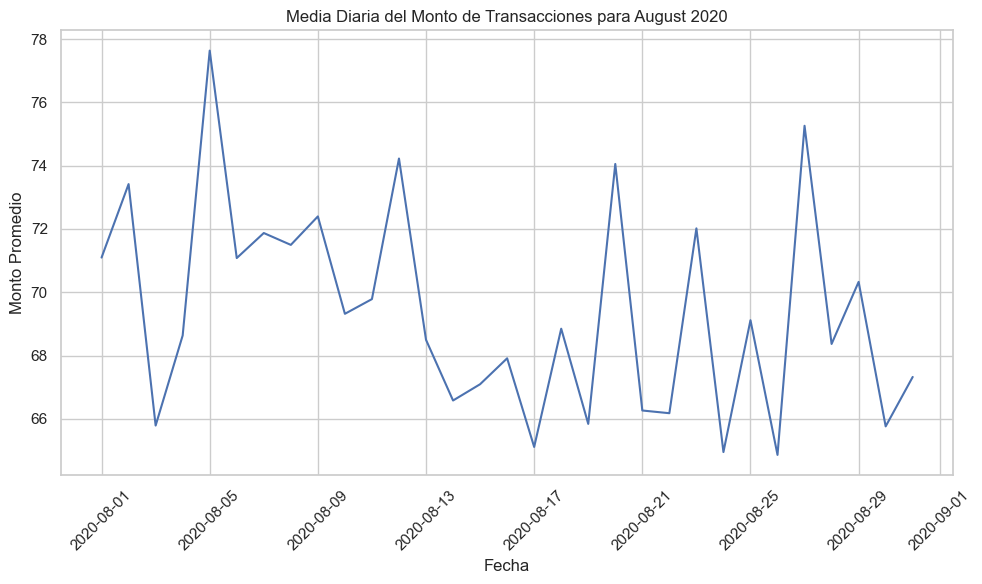

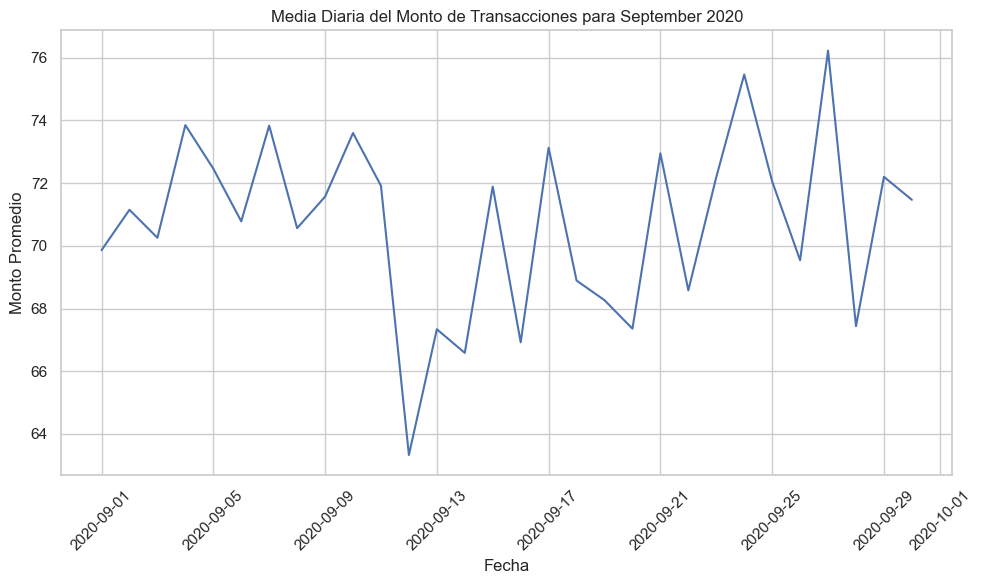

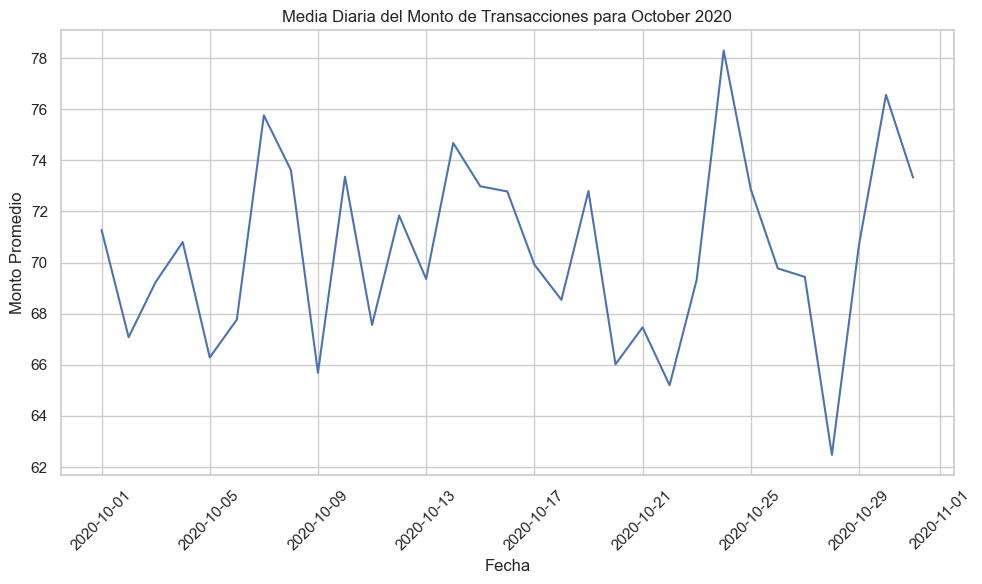

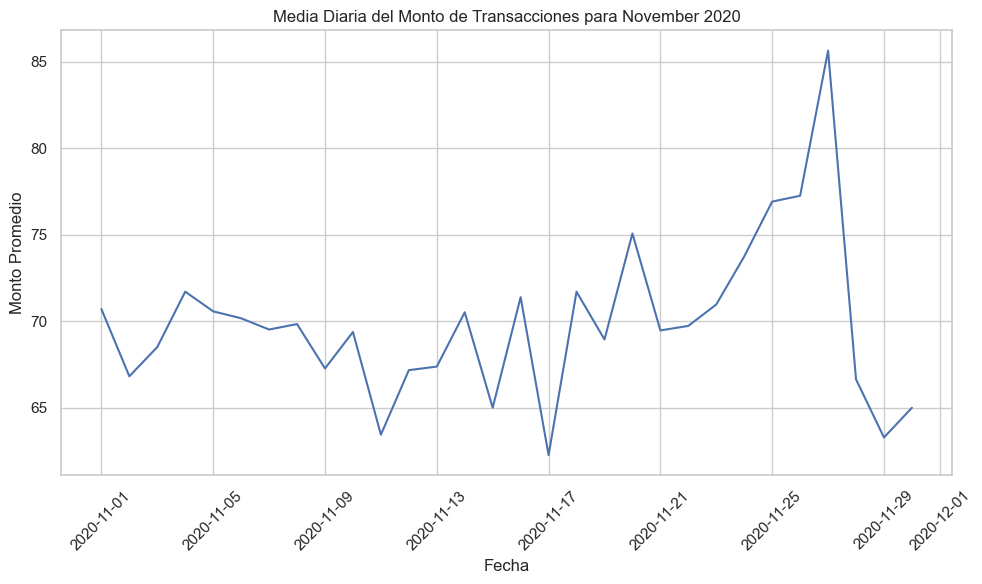

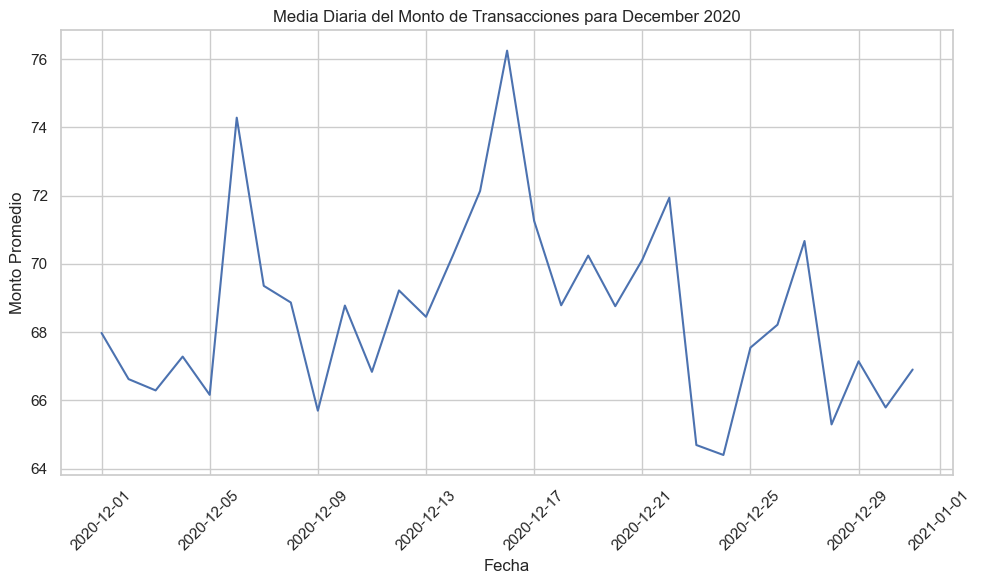

In [12]:
sns.set(style="whitegrid")
monthly_groups = data.groupby(pd.Grouper(freq='M'))
for name, group in monthly_groups:
    plt.figure(figsize=(10, 6))
    daily_avg_amt = group.resample('D')['amt'].mean()

    sns.lineplot(x=daily_avg_amt.index, y=daily_avg_amt.values)
    plt.title(f'Media Diaria del Monto de Transacciones para {name.strftime("%B %Y")}')
    plt.xlabel('Fecha')
    plt.ylabel('Monto Promedio')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.savefig(f"analisis_mensual/transacciones_{name.strftime('%Y_%m')}.png")
    plt.close()


# determinar si hay fraude todos los meses.